# Preamble

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Data Augmentation
import albumentations as A
# import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

# torchvision
import torchvision.transforms.v2 as TF
from torchviz import make_dot

import numpy as np
from PIL import Image
import cv2

# to have a progress bar
from tqdm import tqdm

# To use pretrained segmentation models (implement in PyTorch)
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# visualization
import matplotlib.pyplot as plt
from pprint import pprint


# OS/File/Path management
import os
import sys

# load my custom Classes/Functions/etc.
from utils.models.unet import UnetScratch
from utils.dataset import SegmentaionDataset
from utils.inferencing import inference_segmentation, img_to_inference_tensor
from utils.visualization import torch_tensor_for_plt, plot_segmentation_inference


# from utils import (
#     load_checkpoint,
#     save_checkpoint,
#     get_loaders,
#     check_accuracy,
#     save_pred_as_imgs
# )

/home/tekboart/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/tekboart/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

## Set up GPU use

In [3]:
print('PyTorch ver:', torch.__version__)

# force pytorch to use GPU
# use "model.to(device)" later on to force a model use Cuda GPU
print('Can I use GPU?', torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device used for calculation (CPU\Cuda):', device)

PyTorch ver: 2.0.1+cu118
Can I use GPU? True
Device used for calculation (CPU\Cuda): cuda:0


## Set Hyperparameters

In [4]:
device = device
lr = 1e-4
batch_size = 2
epochs = 1
num_workers = 2
image_height = 384
image_width = 640
num_classes = 1
pin_mem = True
load_model = False
load_model_path = os.path.join('models')
train_img_dir = os.path.join("data", "traindata", "img")
train_mask_dir = os.path.join("data", "traindata", "mask")
val_img_dir = os.path.join("data", "valdata", "img")
val_mask_dir = os.path.join("data", "valdata", "mask")

# Create Dataset

In [5]:
from utils.dataset import get_loaders


# define transformers (resize, rescale, augmentation, etc.)
train_transform = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # this is for z-score
        # for pretrained models on, for instance, imagenet need other values for mean and std.
        A.Normalize(
            mean=[0.0, 0.0, 0, 0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0
        ),
        ToTensorV2(),
    ],
    # TODO: this options seems risky
    is_check_shapes=False,
)

# we don't want TTA, just some resize, normalization, etc.
val_transform = A.Compose(
    [
        A.Resize(height=image_height, width=image_width),
        A.Normalize(
            mean=[0.0, 0.0, 0, 0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0
        ),
        ToTensorV2(),
    ],
    # TODO: this options seems risky
    is_check_shapes=False,
)


# Create Datatset by data loaders
train_loader, val_loader = get_loaders(
    train_img_dir,
    train_mask_dir,
    val_img_dir,
    val_mask_dir,
    batch_size,
    train_transform,
    val_transform,
    num_workers,
    pin_mem,
)

In [7]:
print(len(train_loader))
print(len(val_loader))

14
9


# Define Model(s)

## Import a Pretrained Segmentaion model (e.g., UNET)

In [5]:
# the downloaded model are located in "~/.cache/torch/hub/checkpoints/"
# backbone_model_name = 'resnet152'
backbone_model_name = 'mobilenet_v2'

# Segmentation model is just a PyTorch nn.Module
# model = smp.FPN(
model = smp.Unet(
    encoder_name=backbone_model_name,        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7 
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

# load preprocessing func of the loaded model, so our data goes through the same transformation
# hint 1: it needs the input img to be in channels_last format
# hint 2: it outputs the image in channels_last format! (e.g., toch.Size[640, 360, 3])
preprocess_input = get_preprocessing_fn(backbone_model_name, pretrained='imagenet')

### Visualize the architecture

In [6]:
# the attribs of the model
# vars(model)


# plot the model arch
# create a dumy channels_first img (m, C, H, W)
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
yhat = model(x)

make_dot(yhat, params=dict(list(model.named_parameters()))).render("./outputs/model_architecture/Unet_pretrained", format="png")

'outputs/model_architecture/Unet_pretrained.png'

### Test the model with an img

## Load a Segmentation Model (i.e., UNET), written from scratch

In [6]:
model = UnetScratch(in_channels=3, num_classes=1)

# Train

In [8]:
from utils.training import train_fn

In [7]:
from utils.metrics import check_accuracy

from datetime import datetime
def save_checkpoint(state, dirname: str = '', filename: str = None) -> None:
    '''
    Save the trained model (aka checkpoint)
    '''
    print(' Saving Checkpoint '.center(79, '-'))

    if not filename:
        # get the date+time (of currect TimeZone)
        time = datetime.today().strftime('%Y.%m.%d@%H:%M:%S')
        # get the date+time (of UTC TimeZone)
        # time = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')

        filename = f'{dirname}{time}-model_checkpoint.pth.tar'

    torch.save(state, filename)


def load_checkpoint(checkpoint, model) -> None:
    '''
    Load the weights from a the trained model to another model.

    Parameters
    ----------
    checkpoint
        A previously saved model checkpoint (e.g., using torch.save())
        e.g., my_checkpoint.pth.tar
    '''
    print(' Loading Checkpoint '.center(79, '-'))

    model.load_state_dict(checkpoint["state_dict"])


def train_fn(loader, model, optimizer, loss_fn, scaler):
    """
    does one epoch of training

    Parameters
    ----------
    loader:
        <description>
    model:
        <description>
    optimizer:
        <description>
    loss_func:
        <description>
    scaler:
        <description>

    Returns
    -------

    Raises
    ------

    """
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device)
        targets = targets.float().to(device)

        # forward
        # we use float16 to reduce VRAM and MEM usage
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backprop
        # init all grads az zero/0
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.upate()

        # update the tqdm loop
        loop.set_postfix(loss=loss.item())


def main():
    model = UnetScratch(in_channels=3, num_classes=num_classes).to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # load weights a pretrained model
    if load_model:
        load_checkpoint(torch.load(load_model_path), model)

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(epochs):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save the trained model
        checkpoint = {
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        # of the val set
        check_accuracy(val_loader, model, device=device)

        # print some examples to a folder


###############################################################################
# For testing
###############################################################################
if __name__ == "__main__":
    main()

  0%|          | 0/7 [00:12<?, ?it/s]


KeyboardInterrupt: 

# Inference

/home/tekboart/.local/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


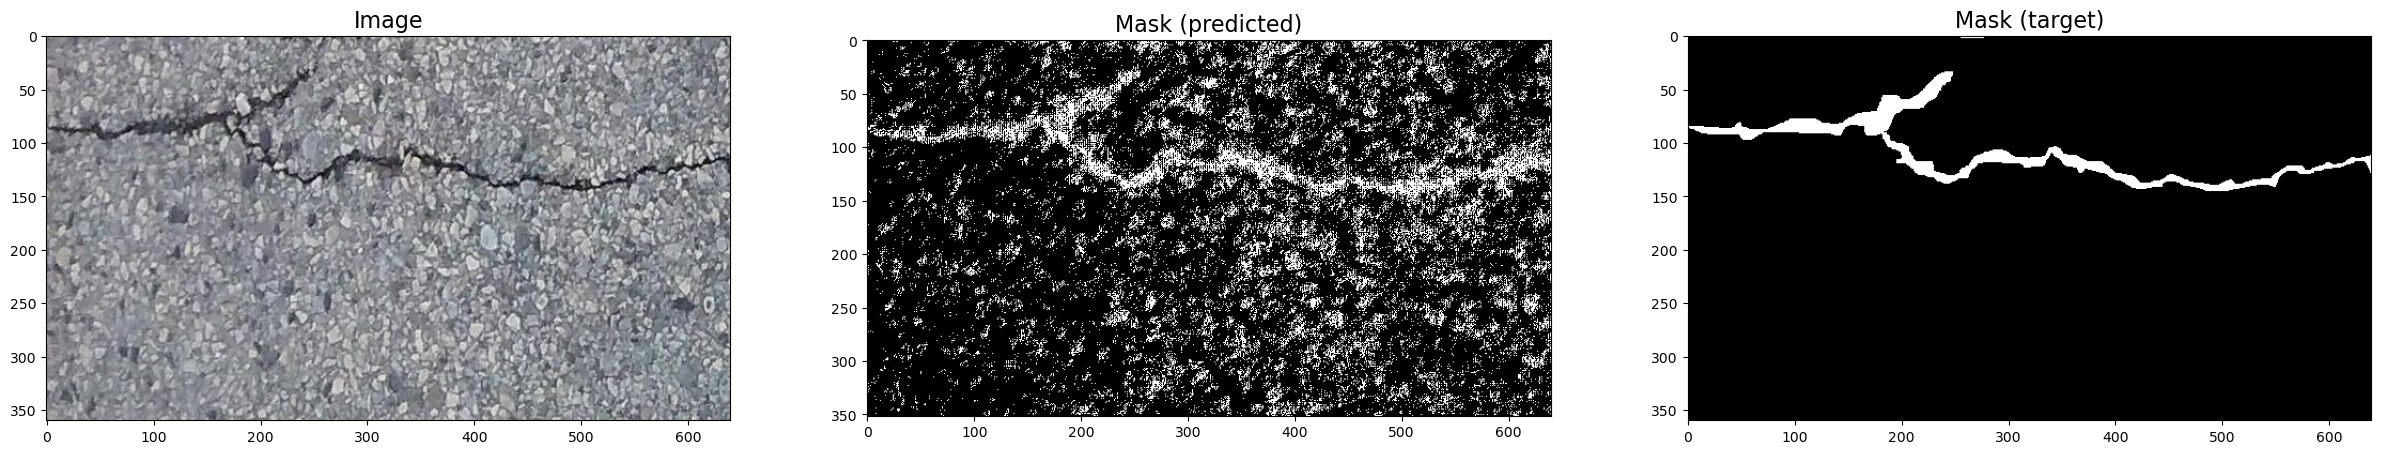

In [ ]:
img_addr = os.path.join('images', '') + '20160222_081011_1_721.jpg'
mask_addr = os.path.join('images', '') + '20160222_081011_1_721_mask.png'

# inference_semantic_seg(img_addr, model=model, thresh=0.5, )

img = Image.open(img_addr)
mask = Image.open(mask_addr)

# normalize [-1, 1] the PIL image as a torch.Tensor
img_tensor = (TF.functional.pil_to_tensor(img) / 127.5 - 1)

yhat = model(img_tensor.unsqueeze(dim=0))
yhat_c_last = yhat[0].moveaxis(0, -1).detach().numpy()
thresh = 0.5
mask_batch = np.where(yhat_c_last >= thresh, 255, 0)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(img)
axes[0].set_title('Image', fontsize=16)
axes[1].imshow(mask_batch, cmap='gray')
axes[1].set_title('Mask (predicted)', fontsize=16)
axes[2].imshow(mask, cmap='gray')
axes[2].set_title('Mask (target)', fontsize=16)
plt.show()

torch.Size([3, 384, 640])
torch.Size([1, 384, 640])


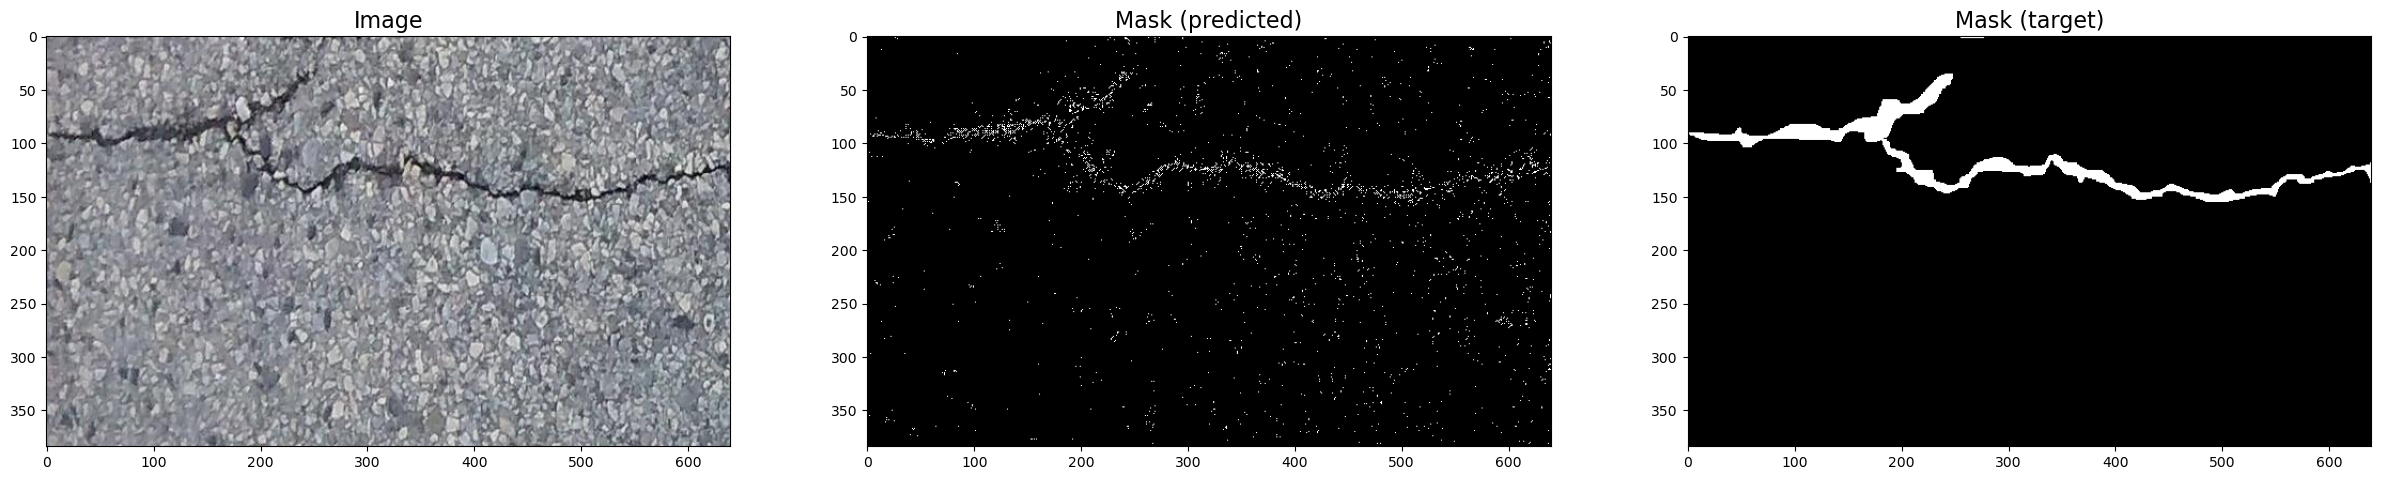

In [12]:
img_addr = os.path.join('images', '') + '20160222_081011_1_721.jpg'
mask_addr = os.path.join('images', '') + '20160222_081011_1_721_mask.png'

# only for one image, if multiple use utils.dataset
test_img_batch = img_to_inference_tensor(img_addr, size=(384, 640))
print(test_img_batch[0].shape)
test_mask_batch = img_to_inference_tensor(mask_addr, size=(384, 640))
print(test_mask_batch[0].shape)

# make an inference
yhat_mask = inference_segmentation(test_img_batch, model=model, normalize=True)

# make torch.Tensors ready for pyplot
test_img_batch = torch_tensor_for_plt(test_img_batch)
test_mask_batch = torch_tensor_for_plt(test_mask_batch)
yhat_mask = torch_tensor_for_plt(yhat_mask)

# plot the inference
plot_segmentation_inference(test_img_batch, test_mask_batch, yhat_mask)

# 